![MIoT_GDPI](img/MIOT_GDPI_header.png)

# Unidad 04 - Introducción a la librería Keras

Una vez finalizado la introducción al paradigma de aprendizaje incremental, nos centraremos ahora en el desarrollo y aplicación de modelos basados en redes neuronales profundas, ya que nos permitirán generar modelos que tengan en cuenta el tiempo. Para poder desarrollar  este tipo de redes, emplearemos Tensorflow y el API de Keras3. Dado que la experiencia en este máster estuvo centrada en en `scikit-learn`, emplearemos esta práctica a modo de introducción al uso de Keras con Tensorflow.





La mayor parte del contenido de este Notebook se dedica a explicar el uso básico del API Keras empleando como *backend* Tensorflow. Es crucial que dediquéis tiempo a leer y comprender el material, en lugar de simplemente ejecutar el código. Os invitamos a experimentar modificando y variando el código proporcionado para que podáis explorar las distintas opciones y profundizar en su funcionamiento.



**Importante**: El Notebook contiene varios ejercicios sencillos. Deberéis desarrollarlos durante la clase y enviarlos por el aula virtual del curso, en la tarea correspondiente


## Referencias útiles para la práctica

1. [Documentación oficial](https://www.tensorflow.org/learn?hl=es-419) de Tensorflow
2. [Guías](https://keras.io/guides/) de Keras




## 1. Introducción 
**Es habitual que en las plantas industriales nos encontremos con procesos secuenciales altamente no lineales y con grandes dependencias temporales**. Pensad que un subproceso que se está aplicando ahora mismo en una parte de la línea a un producto intermedio, no tendrá efecto en el producto final hasta un tiempo después, ya que es necesario que el producto intermedio avance y  atraviese los diferentes subprocesos productivos hasta llegar al final.

En general los modelos vistos hasta ahora no tienen en cuenta el tiempo. Típicamente son "fotos fijas" de un proceso en el que se recogen las medidas o características de ese momento dado. Por ejemplo, cada observación puede estar compuesta de las medidas de todos los sensores desplegados en la factoría en un segundo concreto.
En un proceso secuencial con dependencias temporales, estaríamos asociando a la variable/s de salida/s, características de entrada que no fueron las que realmente afectaron  y generaron dicha salida.

Típicamente. para poder trabajar en esta situación en una línea de producción tenemos 2 opciones:
1. Podemos **alinear los datos**, es decir, tratar de crear observaciones que cuadren las entradas concretas que afectaron a la salida escogida. Esto es algo tremendamente complicado si no se conoce perfectamente el proceso productivo y sus características.
2. Podemos **trabajar con modelos que recuerden y tengan en cuenta lo que ha pasado en instantes anteriores**.

Trabajar con modelos recurrentes que tengan en cuenta el tiempo es algo que suele beneficiar el desarrollo de predictores en plantas industriales pero son más complicados de desarrollar y entrenar. Librerías típicas como `scikit-learn`no contemplan el  desarrollo de este tipo de modelos pero existen otros frameworks centrados en el desarrollo de redes neuronales profundas en general y que permiten crear redes recurrentes de diferentes tipos. [Tensorflow](https://www.tensorflow.org/?hl=es-419) es uno de los *frameworks* más populares 

In [1]:

# Importaciones generales
try:
    import pandas as pd
except ImportError as err:
    !pip install pandas
    import pandas as pd

try:
    import numpy as np
except ImportError as err:
    !pip install numpy
    import numpy as np


try:
    import seaborn as sns
except ImportError as err:
    !pip install seaborn
    import seaborn as sns



try:
    import matplotlib.pyplot as plt
except ImportError as err:
    !pip install matplotlib
    import matplotlib.pyplot as plt

import os

# Asegurarnos de usar Keras 3 con backend TensorFlow
# Es necesario hacerlo antes de cargar Keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# Importaciones de Keras y TensorFlow
try:
    import keras
except ImportError as err:
    !pip install keras
    import keras

try:
    import tensorflow as tf 
except ImportError as err:
    !pip install tensorflow
    import tensorflow as tf 



# Importaciones de Scikit-learn
#Solo para facilitarnos el uso de algunas operaciones típicas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Configuraciones para visualización. No es necesario
plt.style.use('seaborn-v0_8-whitegrid') # Estilo de gráficos
sns.set_palette('viridis') # Paleta de colores


# Verificación de versiones
#Existen diferentes versiones y compatibilidades. Es importantes saber lo que estamos ejecutando
#Para estos ejemplos queremos ejecutar el API de Keras3 (standalone) y tensorflo3>2.16
print(f"Versión de Keras: {keras.__version__}")
print(f"Backend de Keras: {keras.backend.backend()}")
print(f"Versión de TensorFlow: {tf.__version__}")



# Verificar si TensorFlow puede usar GPU en nuestro sistema (opcional, pero bueno saberlo)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU disponible: {gpu_devices}")
else:
    print("GPU no encontrada, se usará CPU.")

2025-05-02 18:21:55.714881: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 18:21:55.721300: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 18:21:55.767930: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 18:21:55.807396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746202915.850554    7910 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746202915.86

Versión de Keras: 3.9.2
Backend de Keras: tensorflow
Versión de TensorFlow: 2.19.0
GPU no encontrada, se usará CPU.


2025-05-02 18:21:58.265640: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Para el desarrollo del ejemplo emplearemos un *dataset* público de Kaggle: [Concrete Compressive Strength Data Set](https://www.kaggle.com/datasets/elikplim/concrete-compressive-strength-data-set/data).
El repositorio contiene una descripción del mismo y de sus campos:


**Concrete Compressive Strength Data Set**


*Abstract: Concrete is the most important material in civil engineering. The
concrete compressive strength is a highly nonlinear function of age and
ingredients. These ingredients include cement, blast furnace slag, fly ash,
water, superplasticizer, coarse aggregate, and fine aggregate.*

| **Nombre** | **Tipo de dato** | **Medida** | **Descripción** |
|---|---|---|---|
| Cement (component 1) | quantitative | kg in a m³ mixture | Input Variable |
| Blast Furnace Slag (component 2) | quantitative | kg in a m³ mixture | Input Variable |
| Fly Ash (component 3) | quantitative | kg in a m³ mixture | Input Variable |
| Water (component 4) | quantitative | kg in a m³ mixture | Input Variable |
| Superplasticizer (component 5) | quantitative | kg in a m³ mixture | Input Variable |
| Coarse Aggregate (component 6) | quantitative | kg in a m³ mixture | Input Variable |
| Fine Aggregate (component 7) | quantitative | kg in a m³ mixture | Input Variable |
| Age | quantitative | Day (1\~365) | Input Variable |
| **Concrete compressive strength** | quantitative | MPa | Output Variable |



Descargamos la última versión del dataset empleando `kagglehub`.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elikplim/concrete-compressive-strength-data-set")

print("Path to dataset files:", path)
#Nombre del fichero descargado: concrete_data.csv
df_concrete=pd.read_csv(path+"/concrete_data.csv")



Path to dataset files: /home/david/.cache/kagglehub/datasets/elikplim/concrete-compressive-strength-data-set/versions/1


## Análisis de los datos


**IMPORTANTE**: *el objetivo  de este Notebook es desarrollar modelos con Keras y Tensorflow, por lo que simplificaremos al máximo las fases de análisis y preprocesado. El rendimiento del modelo no es prioritario. Conocéis de materias previas la importancia de analizar y preparar los datos  para mejorar la precisión de los modelos.*

**Recordad** que un análisis profundo de los datos implica

In [4]:
print(f"Numero de filas: {len(df_concrete)}")
print(f"Numero de características: {len(df_concrete.columns)}")

print("Información general del dataset:")
df_concrete.info()


 # Vistazo rápido a los datos
print("Primeras filas del dataset:")
print(df_concrete.head())



# Comprobar valores nulos 
print("Valores nulos por columna:")
print(df_concrete.isnull().sum())

Numero de filas: 1030
Numero de características: 9
Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_slag             1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_aggregate               1030 non-null   float64
 6   fine_aggregate                 1030 non-null   float64
 7   age                            1030 non-null   int64  
 8   concrete_compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
Primeras filas del dataset:
   cement  blast_furnace_slag  fly_ash  water  superplasticizer  \
0   

Aunque no es el objetivo de este Notebook, un analisis detallado de los datos para "aprender" de estos con el objetivo de crear operaciones de preprocesado que mejoren el modelo, requiere que se dividan los datos para evitar el llamado "sesgo de espionaje".

Datos de entrenamiento: (721,9)
Datos de validacion: (154,9)
Datos de test: (155,9)
Estadísticas descriptivas del conjunto de entrenamiento:
                               count        mean         std     min     25%  \
cement                         721.0  284.412344  108.360156  102.00  192.00   
blast_furnace_slag             721.0   74.972399   87.717518    0.00    0.00   
fly_ash                        721.0   52.007490   63.707622    0.00    0.00   
water                          721.0  181.806380   21.158364  121.80  165.60   
superplasticizer               721.0    6.126768    6.046401    0.00    0.00   
coarse_aggregate               721.0  973.798474   78.509319  801.00  932.00   
fine_aggregate                 721.0  771.637725   80.125986  594.00  724.30   
age                            721.0   46.049931   61.650743    1.00   14.00   
concrete_compressive_strength  721.0   36.152732   16.803538    2.33   23.89   

                                  50%      75%     max  
c

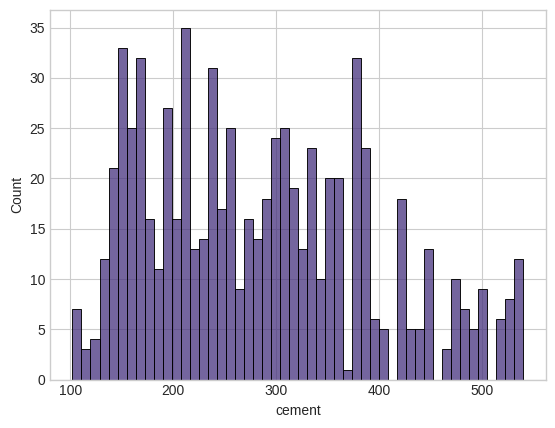

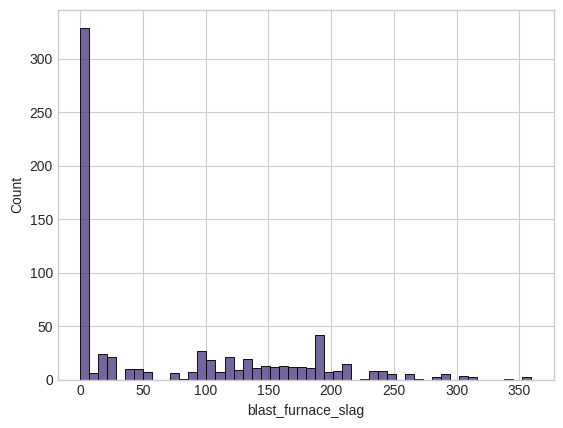

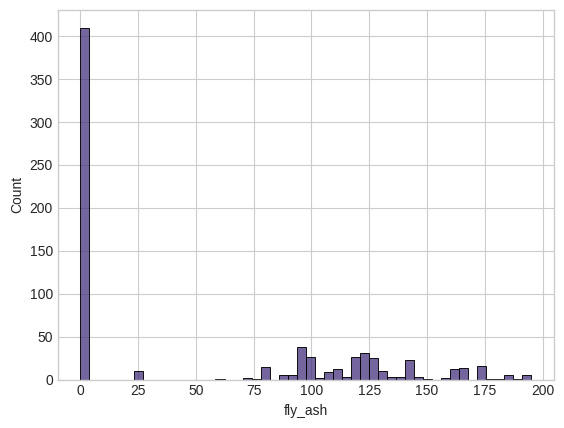

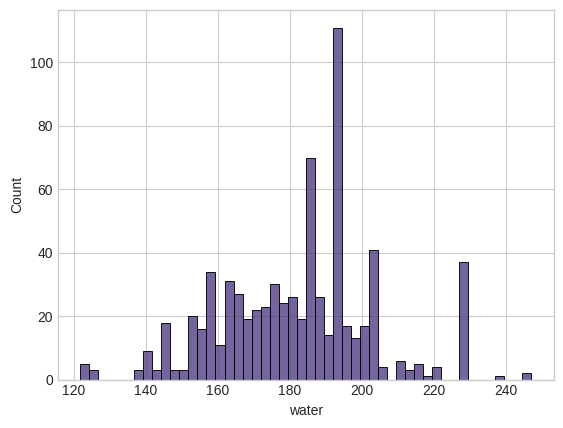

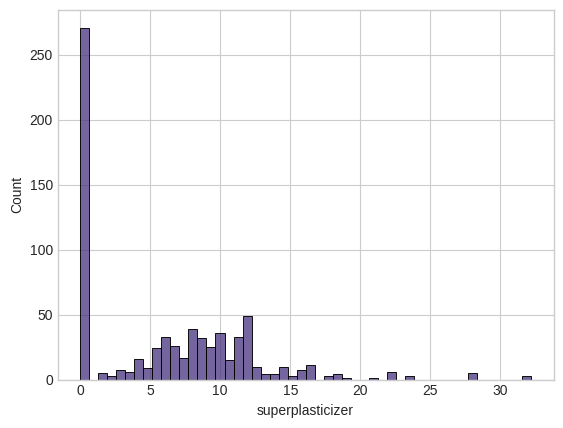

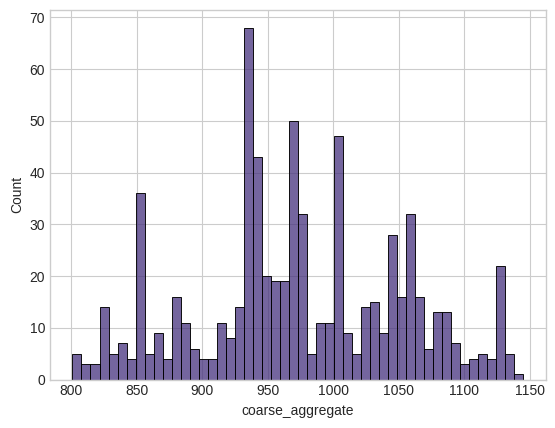

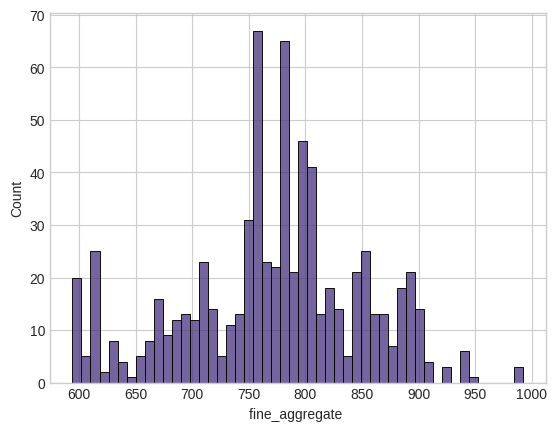

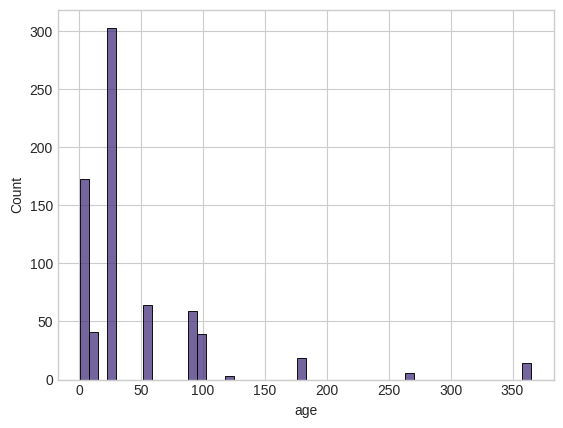

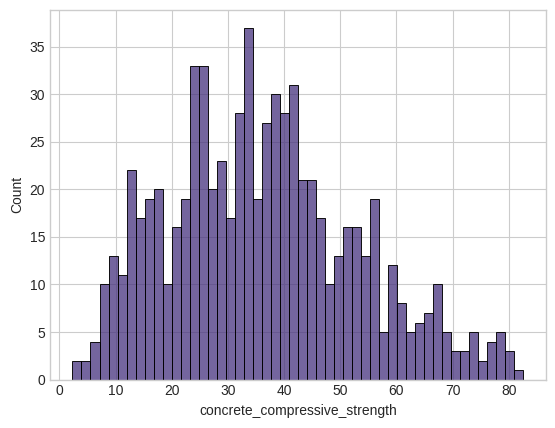

NameError: name 'heatmap' is not defined

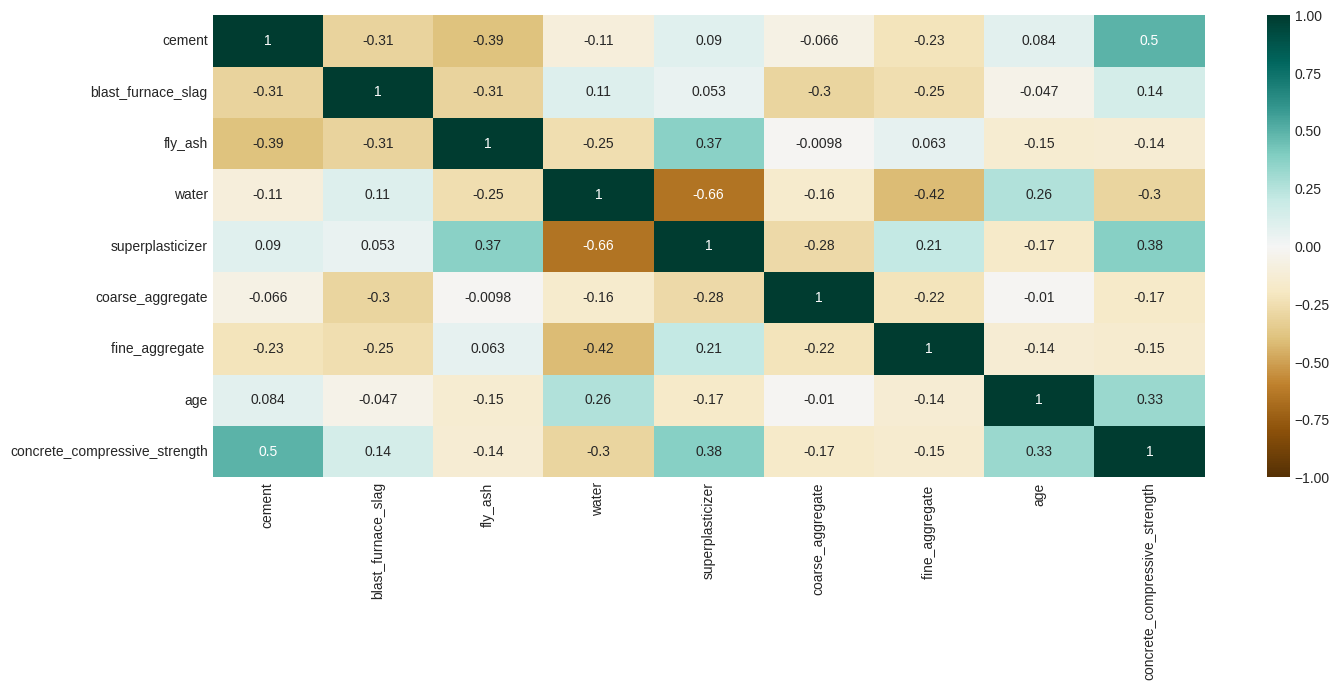

In [11]:
# Establecemos una semilla para la reproducibilidad. 
#Emplearemos esta semilla para todos los procesos pseudoaleatorios
SEED=42


#Separamos las entradas de las salidas
#df_concrete_inputs = df_concrete.drop('concrete_compressive_strength', axis=1)
#df_concrete_outputs = df_concrete['concrete_compressive_strength']


#Dividimos en entrenamiento, validación y test 
# Usaremos un 70% para entrenamiento, un 15% para Validación y un 15% para Test.
#Nos devuelve un array de numpy

concrete_train, concrete_pruebas=train_test_split(df_concrete, test_size=0.30, random_state=SEED)
concrete_val, concrete_test=train_test_split(concrete_pruebas, test_size=0.50, random_state=SEED)



#Convertimos a DataFrames para mejor visualización (opcional)
df_concrete_train = pd.DataFrame(concrete_train, columns=df_concrete.columns)
df_concrete_val = pd.DataFrame(concrete_val, columns=df_concrete.columns)
df_concrete_test = pd.DataFrame(concrete_test, columns=df_concrete.columns)

print(f"Datos de entrenamiento: ({len(df_concrete_train)},{len(df_concrete_train.columns)})")
print(f"Datos de validacion: ({len(df_concrete_val)},{len(df_concrete_val.columns)})")
print(f"Datos de test: ({len(df_concrete_test)},{len(df_concrete_test.columns)})")






print("Estadísticas descriptivas del conjunto de entrenamiento:")
print(df_concrete_train.describe().transpose())


for col in df_concrete_train.columns:
    sns.histplot(data=df_concrete_train[col], bins=50)
    plt.show() # Seaborn configura implícitamente el objeto plt


plt.figure(figsize=(16, 6))
sns.heatmap(df_concrete_train.corr(),vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap');



## Preparación de los datos
Preparación mínima de los datos para poder construir el modelo. Realizaremos un preprocesado de los mismos. En particular estandarizaremos los valores de las características. En lugar de estandarizar los datos a través de una operación de `scikit-learn` (sistema que ya conocéis), lo haremos desde el propio Keras generando una capa de preprocesado. Esto tiene como ventaja poder incluirlo en el propio modelo y que este sea autosuficiente.

In [19]:
#separamos las entradas de las salidas
df_concrete_train_X=df_concrete_train.drop('concrete_compressive_strength', axis=1)
df_concrete_train_y=df_concrete_train['concrete_compressive_strength']

df_concrete_val_X=df_concrete_val.drop('concrete_compressive_strength', axis=1)
df_concrete_val_y=df_concrete_val['concrete_compressive_strength']

df_concrete_test_X=df_concrete_test.drop('concrete_compressive_strength', axis=1)
df_concrete_test_y=df_concrete_test['concrete_compressive_strength']





normalization_layer = keras.layers.Normalization(axis=-1) # Normaliza a través del eje de características

# Keras espera un array NumPy o Tensor, no un DataFrame directamente.
normalization_layer.adapt(df_concrete_train_X.values)
print(f"  Medias aprendidas: {normalization_layer.mean.numpy()}")
print(f"  Varianzas aprendidas: {normalization_layer.variance.numpy()}")

#Probamos la estandarización con los datos de entrenamiento
df_concrete_train_X_scaled=normalization_layer(df_concrete_train_X.values)
print("Media de las entradas del dataset de entrenamiento escalado (debería ser cercana a 0):")
#La capa devuelve un tensor que es necesario pasar a un array de numpy
print(df_concrete_train_X_scaled.numpy().mean())
print("Desviación estándar de las entradas del dataset de entrenamiento escalado (debería ser cercana a 1):")
print(df_concrete_train_X_scaled.numpy().std())





  Medias aprendidas: [[284.41235    74.9724     52.00749   181.80638     6.1267686 973.79846
  771.6377     46.04993  ]]
  Varianzas aprendidas: [[11725.638    7683.691    4053.0317    447.05545    36.50826  6155.1646
   6411.269    3795.5425 ]]
Media de las entradas del dataset de entrenamiento escalado (debería ser cercana a 0):
4.3980126e-08
Desviación estándar de las entradas del dataset de entrenamiento escalado (debería ser cercana a 1):
1.0


## Construcción del modelo

Keras permite general modelos empleando dos opciones:
1. El [API secuencial](https://keras.io/guides/sequential_model/): Permite generar redes densas con diferentes capas donde cada capa tiene exactamente un tensor de entrada y un tensor de salida. Se generan capas que se unen (apilan) secuencialmente.
2. El [API funcional](https://keras.io/guides/functional_api/): permite crear modelos más flexibles que los secuenciales. Esta API permite gestionar modelos con topologías no lineales. Permite crear "grafos de capas".



Vamos a definir nuestra red neuronal usando el API Secuencial de Keras (`keras.Sequential`), que es suficiente crear un modelo que "apile"  capas una tras otra.


Definiremos una red sencilla:
- Capa de Entrada: Definida implícitamente por input_shape en la primera capa densa. Debe coincidir con el número de características (8 en nuestro caso). 
- Capas Ocultas: Usaremos un par de capas densas (`keras.layers.Dense`) con activación ReLU (`relu`). ReLU es una opción común y eficiente para capas ocultas. El número de neuronas es un hiperparámetro a optimizar (empezaremos con 32 y 16).
- Capa de Salida: Una única neurona (Dense(1)) ya que es un problema de regresión (predecir un solo valor continuo). No usaremos función de activación (o equivalentemente, activación 'linear'), porque queremos que la salida pueda tomar cualquier valor real, no limitado a un rango específico.

Explicación del código:
- keras.Sequential([...]): Crea un modelo donde las capas se ejecutan en secuencia.
- keras.Input(shape=(n_features,)): Define formalmente la forma de los datos de entrada. Ayuda a Keras a construir el modelo correctamente.
- keras.layers.Dense(units, activation=...): Define una capa totalmente conectada (densa). units es el número de neuronas. activation es la función de activación.
- model.summary(): Muestra las capas, la forma de salida de cada capa y el número de parámetros entrenables. Es útil para verificar la arquitectura.
    
   

In [47]:
# Establece la semilla para los números aleatorios con  keras.utils.set_random_seed. Esto establecerá:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
#Permitir la reproducibilidad es clave para poder comparar
keras.utils.set_random_seed(SEED)


# Obtenemos el número de características para la capa de entrada
n_features = len(df_concrete_train_X.columns)
print(f"Número de características de entrada: {n_features}")

# Construcción del modelo secuencial
model = keras.Sequential(
    [
        keras.Input(shape=(n_features,), name="input_layer"), # Capa de entrada explícita. 
                                                              #No es obligatoria pero nos permite ver el resumen 
                                                              #completo de la red al crearla, incluyendo los pesos
        normalization_layer, #capa de normalización que generamos anteriormente. El modelo es autosuficiente
        keras.layers.Dense(64, activation='tanh', name='hidden_layer_1'), # 1ra capa oculta con 32 neuronas y activación ReLU
        keras.layers.Dense(32, activation='tanh', name='hidden_layer_2'), # 2da capa oculta con 16 neuronas y activación ReLU
        keras.layers.Dense(1, activation='linear', name='output_layer')   # Capa de salida con 1 neurona (regresión) y activación lineal
    ],
    name="Concrete_Strength_Predictor" # Nombre opcional para el modelo
)


# Mostrar un resumen de la arquitectura del modelo
print("\nResumen del modelo:")
model.summary()

Número de características de entrada: 8

Resumen del modelo:


Model: "Concrete_Strength_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_6 (Normalization) │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,706 (10.57 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 17 (72.00 B)

## Compilación del modelo


Antes de entrenar, necesitamos "compilar" el modelo. Esto implica configurar:

* **Optimizador**: Algoritmo que ajusta los pesos de la red durante el entrenamiento(ej. Adam, SGD, RMSprop). Adam es una opción robusta y popular. Tenéis [aquí](https://keras.io/api/optimizers/) un listado de los disponibles.

* **Función de Pérdida** (*Loss Function*): Mide qué tan bien se desempeña el modelo durante el entrenamiento. Para regresión, mean_squared_error (MSE) es una opción muy típica. Tenéis [aquí](https://keras.io/api/losses/) un listado de los disponibles.


* **Métricas**: Funciones para evaluar el rendimiento del modelo (ej. mean_absolute_error - MAE). **Las métricas no se usan para optimizar el modelo, solo para monitorizarlo**. Tenéis [aquí](https://keras.io/api/metrics/) un listado de las disponibles

In [48]:
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001), # Optimizador Adam con tasa de aprendizaje típica
        loss='mean_squared_error',          # Función de pérdida para regresión (MSE)
        metrics=[keras.metrics.MeanAbsoluteError(name='mae')] # Métrica para monitorear (MAE)
    )

print("Modelo compilado exitosamente.")
print(f"Optimizador: {type(model.optimizer).__name__}")
print(f"Función de pérdida: {model.loss}")
print("Métricas: ")
#metricas incluye la empleada como función de pérdida
for m in model.metrics:
    print(m.name)


Modelo compilado exitosamente.
Optimizador: Adam
Función de pérdida: mean_squared_error
Métricas: 
loss
compile_metrics


## Entrenamiento del modelo
Ahora entrenaremos el modelo con nuestro dataset de entrada. Recordad que el modelo contiene una capa de normalización, por lo que los datos que se le pasen para entrenar NO pueden estar normalizados (lo hará el propio modelo).


El método `fit` es el empleado para entrenar. Tenéis [aquí](https://keras.io/api/models/model_training_apis/#fit-method) disponible todos los parámetros posibles. En este caso emplearemos:

* **epochs**: Número de veces que el modelo verá el conjunto de datos completo.
* **batch_size**: Número de muestras procesadas antes de actualizar los pesos (entrenamiento con *mini-batches*).
* **validation_data**: conjunto de datos sobre los que validaremos el entrenamiento del modelo. Lo podemos emplear para comparar configuraciones o para parar el entrenamiento de forma prematura (*early_stopping*), lo que puede ayudar a detectar el *overfitting*.

El método `fit` devuelve un objeto *History* que contiene información sobre el proceso de entrenamiento (pérdida y métricas en cada época) que podremos utilizar posteriormente para graficar el proceso de entreno.

In [49]:
##IMPORTANTE: si se vuelve a ejecutar esta celda sin generar el modelo desde 0
##Partiréis de los pasos del último entrenamiento
# Definimos el número de épocas y el tamaño del batch
EPOCHS = 1000
BATCH_SIZE = 256

# Entrenamos el modelo
history = model.fit(
    df_concrete_train_X.values,
    df_concrete_train_y.values,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(df_concrete_val_X.values, df_concrete_val_y.values),
    verbose=0 # Muestra una barra de progreso por época (0=silencioso, 1=barra, 2=una línea por época)
)

## Evaluación del Modelo

Evaluaremos el rendimiento del modelo de dos maneras:

1. Visualizando el historial de entrenamiento: Graficaremos la pérdida y la métrica (MAE) tanto para el conjunto de entrenamiento como para el de validación a lo largo de las épocas. Esto nos ayuda a diagnosticar problemas como el overfitting (cuando la pérdida de validación empieza a aumentar mientras la de entrenamiento sigue bajando) o el underfitting (cuando ambas pérdidas son altas).
2. Evaluando en el conjunto de Test: Usaremos el método `evaluate` con los datos de Test (X_test_scaled, y_test), que el modelo nunca ha visto. Esto nos da una estimación final e imparcial del rendimiento del modelo.


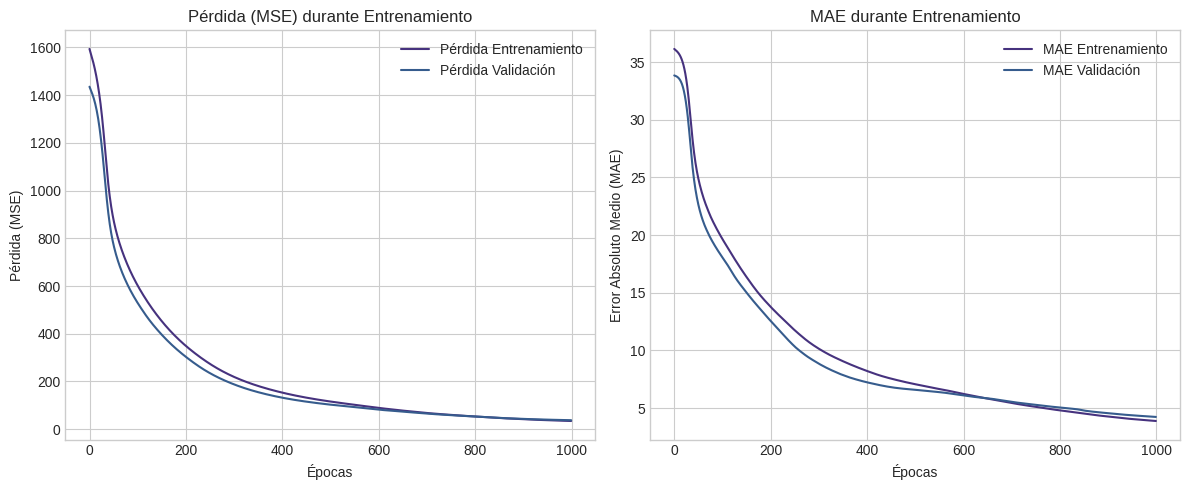

Evaluando el modelo en el conjunto de prueba. Métrica general
Pérdida en el conjunto de Test (MSE): 38.9457
Error Absoluto Medio (MAE) en el conjunto de Test: 4.5921
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Coeficiente de Determinación (R²) en el conjunto de Test: 0.8444


Text(0, 0.5, 'Predicciones')

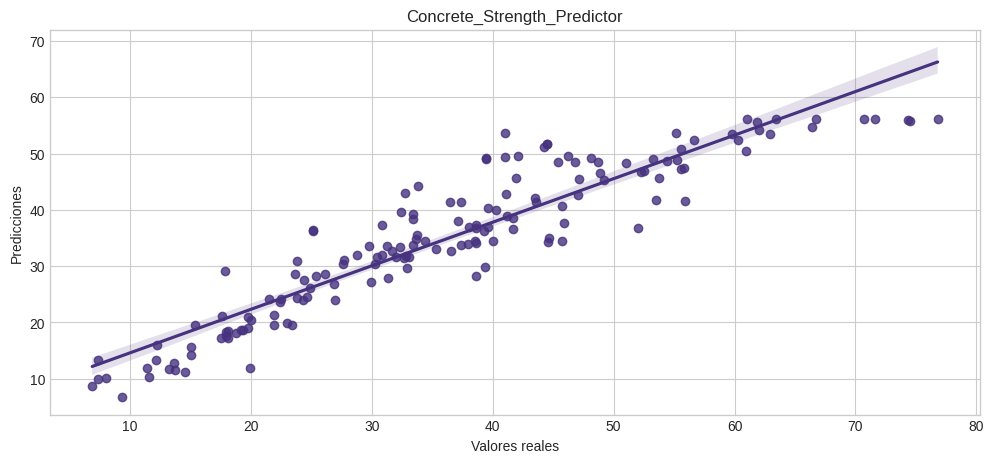

In [62]:
def graficas_entrenamiento(hist):
    hist=pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(hist['epoch'], hist['loss'], label='Pérdida Entrenamiento')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Pérdida Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (MSE)')
    plt.title('Pérdida (MSE) durante Entrenamiento')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    # Asegúrate de usar el nombre correcto de la métrica (puede variar ligeramente)
    mae_key = 'mae' if 'mae' in hist.columns else list(hist.columns)[1] # Intenta encontrar la clave MAE
    val_mae_key = 'val_' + mae_key
    plt.plot(hist['epoch'], hist[mae_key], label='MAE Entrenamiento')
    plt.plot(hist['epoch'], hist[val_mae_key], label = 'MAE Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Error Absoluto Medio (MAE)')
    plt.title('MAE durante Entrenamiento')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


#1. Graficar el entrenamiento por épocas. Ayuda a valorar el posible (sobre/infra)entrenamiento
graficas_entrenamiento(history)

# 2. Evaluar en el conjunto de prueba
print("Evaluando el modelo en el conjunto de prueba. Métrica general")
test_loss, test_mae = model.evaluate(df_concrete_test_X.values, df_concrete_test_y.values, verbose=0)

print(f"Pérdida en el conjunto de Test (MSE): {test_loss:.4f}")
print(f"Error Absoluto Medio (MAE) en el conjunto de Test: {test_mae:.4f}")

y_pred_test = model.predict(df_concrete_test_X.values) # Aplanar para que tenga la misma forma que y_test

# Calcular R^2 score (opcional, pero útil en regresión)
r2 = r2_score(df_concrete_test_y.values, y_pred_test)
print(f"Coeficiente de Determinación (R²) en el conjunto de Test: {r2:.4f}")

#Scatterplot entre los valores reales y los predichos
plt.figure(figsize=(12, 5))
sns.regplot(x=df_concrete_test_y.values, y=y_pred_test.flatten())
plt.title("Concrete_Strength_Predictor")
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')


## Almacenamiento del modelo
Una vez entrenado el modelo es necesario guardarlo para poder desplegarlo en producción en el futuro. Este es un proceso sencillo en Keras y que se realiza a través del método `save` que podéis consultar [aquí](https://keras.io/api/models/model_saving_apis/model_saving_and_loading/#save-method). Este método guarda toda la información necesaria para el modelo el un archivo comprimido `.keras` con el siguiente contenido:

- La arquitectura del modelo.
- Los pesos del modelo.
- El estado del optimizador (si tiene).
  


In [68]:
PATH_SAVED_MODEL="./concrete_model.keras"

model.save(filepath=PATH_SAVED_MODEL)
del model #eliminamos de memoria el modelo para estar seguros de que no lo tenemos cargado



NameError: name 'model' is not defined

## Cargar el modelo
Una vez tenemos un modelo entrenado y almacenado, deberemos desplegarlo en producción. Para ello cargaremos el modelo a través del método `load_model`

In [70]:
model=keras.saving.load_model(PATH_SAVED_MODEL)
model.summary()

Model: "Concrete_Strength_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_6 (Normalization) │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,086 (31.59 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 17 (72.00 B)

 Optimizer params: 5,380 (21.02 KB)

In [95]:
#Suponiendo que obtenemos datos desde un flujo de datos en tiempo real

for observacion in range(5):
    fila=df_concrete_train_X.iloc[observacion].values
    fila_preparada=np.expand_dims(fila, axis=0)
  
    prediction=model.predict(fila_preparada, verbose=0)
    print(f"La predicción es {prediction}")



(1, 8)
La predicción es [[29.556267]]
(1, 8)
La predicción es [[18.859188]]
(1, 8)
La predicción es [[26.81974]]
(1, 8)
La predicción es [[26.686756]]
(1, 8)
La predicción es [[35.36443]]
